In [1]:
# for SWH collection

# class and defs for processing the CryoSat tracks into DOT
import numpy as np
import pandas as pd
import datetime as dt
import copy
import itertools
import glob
import sys
import imp
import gc
# sys.path.insert(0, '/Users/H/WAVES/geo_data_group/')
sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import data_year as dy
import grid_set as gs
from netCDF4 import Dataset
from invoke import run
from numba import jit
from scipy import stats
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from mpl_toolkits.basemap import Basemap
from astropy.convolution import convolve
from astropy.convolution import kernels

import matplotlib.pyplot as plt
import imageio
imp.reload(gs)
imp.reload(dy)

<module 'data_year' from '/Users/h/Github/geo_data_group/data_year.py'>

In [3]:
# get a file - load the swh
# file = '/Volumes/BU_extra/CryoSat/SWH/swh_arrays/'
# file = '/Users/H/WAVES/SWH/swh_arrays/SWH_anto_100km_1day_2011_raw.npz'
file = '/Volumes/BU_extra/CryoSat/SWH/swh_arrays/SWH_anto_100km_1day_2011-2019_raw.npz'
swh_all = dy.load_data_year(file)
file = '/Volumes/BU_extra/CryoSat/SWH/swh_arrays/SWH_anto_100km_1day_2011-2019_SAR_bin.npz'
swh_SAR_bin = dy.load_data_year(file)
file = '/Volumes/BU_extra/CryoSat/SWH/swh_arrays/SWH_anto_100km_1day_2011-2019_SAR_binc.npz'
swh_SAR_binc = dy.load_data_year(file)
file = '/Volumes/BU_extra/CryoSat/SWH/swh_arrays/SWH_anto_100km_1day_2011-2019_LRM_bin.npz'
swh_LRM_bin = dy.load_data_year(file)
file = '/Volumes/BU_extra/CryoSat/SWH/swh_arrays/SWH_anto_100km_1day_2011-2019_LRM_binc.npz'
swh_LRM_binc = dy.load_data_year(file)
# # file = 'First_saves_2014/SWH_100km_1d_201208'
# # file = 'First_saves_2014/100km_1day_2014-04.npz'
# # file = 'First_saves_2014/50km_5day_2014-04.npz'
# # swh_all = dy.load_data_year(file+'_raw.npz')
# # swh_fill = dy.load_data_year(file+'_filled.npz')

In [2]:
file = '/Volumes/BU_extra/CryoSat/SWH/swh_arrays/nasa_daily_anto_for_SWH.npz'
ice_binned = dy.load_data_year(file)

In [5]:
swh_all.dates[0],swh_all.dates[-1]

(datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2019, 12, 30, 0, 0))

In [6]:
ice_binned.dates[0],ice_binned.dates[-1]

(datetime.datetime(2010, 12, 31, 0, 0), datetime.datetime(2019, 12, 29, 0, 0))

In [7]:
ice_binned.dates = swh_all.dates

In [4]:
ice_binned.mask = np.zeros_like(ice_binned.data,dtype=bool)
ice_binned.mask[ice_binned.data>0.15] = True

In [9]:

ice_binned.build_static_mask(np.isfinite(G.mask.T))

In [55]:
idx = swh_all.yrpd[6:9+1,365].compressed()
np.shape(idx)[0]

0

In [14]:
# check for missing data
ind_check = swh_all.get_index(dt.datetime(2019,8,1))
nnan = np.sum(np.isnan(swh_all.clim_mean(year_set=[8,9])))
end_p = swh_all.n_t-nnan
swh_all.print_date(end_p-1)

/Users/h/Github/geo_data_group/data_year.py:552: RuntimeWarning: Mean of empty slice
  temp_array[pind] = np.nanmean(temp)


'2019-05-02'

In [8]:
G.inflate_mask(160e3)

In [10]:
# temp = swh.ravel(mask=True) 
ocean_only = np.ones_like(ice_binned.data)
ocean_only_m = np.ones_like(ice_binned.data,dtype=bool)
ocean_only[ice_binned.mask] = np.nan
# ocean_only[ice_binned>0.15] = np.nan
ocean_only_m[ice_binned.mask] = False

swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(np.isfinite(G.mask.T))


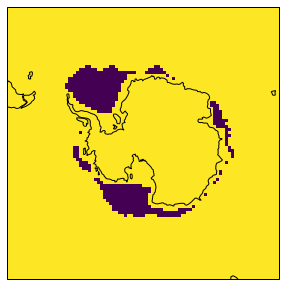

In [11]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
# need regional masking methods
# m.pcolormesh(G.xpts,G.ypts,G.mask.T)
# m.pcolormesh(G.xpts,G.ypts,ice_binned.mask[1943])
ax.pcolormesh(G.xpts,G.ypts,ocean_only_m[1555])
# m.pcolormesh(G.xpts,G.ypts,np.sum(ocean_only_m,axis = 0))
# m.pcolormesh(G.xpts,G.ypts,swh_all[1555])
# m.pcolormesh(G.xpts,G.ypts,swh_all.mask[1555])
# m.pcolormesh(G.xpts,G.ypts,ice_binned[1555])
# m.colorbar()
# plt.drawcoastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.show()

In [17]:
# check for missing data
# end_p = swh_all.get_index(dt.datetime(2014,5,1))
# nnan = np.sum(np.isnan(swh_all.clim_mean(year_set=[8,9])))
# end_p = swh_all.n_t-nnan
swh_all.print_date(end_p-1)

'2019-05-02'

In [5]:
# set grid - 50 km
# tp = np.shape(swh_all)[0]
tp = swh_all.n_t

# m = Basemap(projection='spstere', lon_0=0.0, lat_0 = -90,boundinglat=-45)
m = ccrs.SouthPolarStereo()
G = gs.grid_set(m)
G.load_grid('/Users/H/WAVES/DOT_processing/grids/Polar_stereo_100km_SH.npz')
G.load_mask('/Users/H/WAVES/DOT_processing/grids/Polar_stereo_100km_SH_mask.npz')

Loaded a grid: /Users/H/WAVES/DOT_processing/grids/Polar_stereo_100km_SH.npz
Loaded mask,  106  x  106  inflated by  0.0


In [12]:
offset_mask = swh_LRM_binc.data>3
offset_mask[swh_SAR_binc.data<4] = False

In [13]:
offset = swh_LRM_bin.data-swh_SAR_bin.data

In [14]:
offset[offset_mask==False] = np.nan

In [15]:
d = 20
offset[d,offset_mask[d]].ravel()
swh_SAR_bin.data[d,offset_mask[d]].ravel()

array([2.03589212, 3.1879837 , 3.25896788, 2.61211716, 1.67103546,
       2.12176812, 2.51627021, 1.35440746, 2.32363462, 2.47740026,
       3.4011951 ])

In [16]:
offset_m = np.ones_like(offset)
offset_l = np.ones_like(offset)
for t in range(swh_all.n_t):
    offset_m[t,:,:] = np.floor(t/30)
    offset_l[t,:,:] = G.lats.T
offset_m[offset_mask==False] = np.nan

In [17]:
offset_dy = dy.data_year(offset,swh_all.dates,periods = 365)
offset_dy.mask = offset_mask

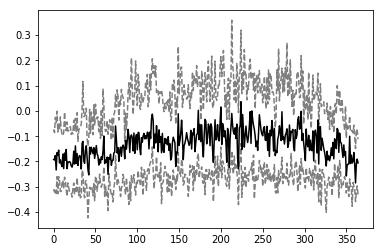

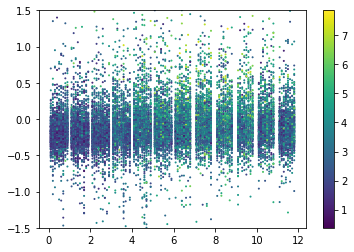

In [74]:

# plt.plot(np.nanmean(offset,axis=(1,2)))
ax = plt.plot(offset_dy.clim_centile([25,50,75],time_set=[0,end_p]))
# ax = plt.plot(offset_dy.clim_mean())
for i in [0,2]:
    ax[i].set_linestyle('dashed')
    ax[i].set_color('k')
    ax[i].set_alpha(0.5)
i = 1
ax[i].set_color('k')
# ax[2].linestyle = 
plt.show()
plt.scatter(np.mod(offset_m[offset_mask].ravel(),12)+
#             offset_m[offset_mask].ravel()-
            (np.floor(offset_m[offset_mask].ravel()/12)+1)/10,
            offset[offset_mask].ravel(),s=1,c=swh_all.data[offset_mask].ravel())
plt.colorbar()
plt.ylim([-1.5,1.5])
plt.show()

In [18]:
pf = np.polynomial.polynomial.polyfit
x=swh_LRM_bin.data[offset_mask].ravel()
y=swh_SAR_bin.data[offset_mask].ravel()
# y=offset[offset_mask].ravel()
# plt.scatter(x,y, s=0.2)
bp,mp = pf(x,y,1)
bt = str(round(bp,3))
mt = str(round(mp,3))
bp, mp

(0.3875136075049559, 0.9016271429364395)

In [19]:
pf = np.polynomial.polynomial.polyfit
x=swh_all.data[offset_mask].ravel()
y=offset[offset_mask].ravel()
# plt.scatter(x,y, s=0.2)
bp,mp = pf(x,y,1)
bt = str(round(bp,3))
mt = str(round(mp,3))
bp+ mp* 1.0

-0.23260875906646206

In [97]:
# SWH = bp + mp(LRM -SAR)*SWH

In [77]:
#(1-b/SWH)/m + SAR
'LRM SWH = SAR SWH + (1.0 - '+bt+'/SWH)/'+mt+')'

'LRM SWH = SAR SWH + (1.0 - -0.301/SWH)/0.068)'

In [78]:
'LRM - SAR offset ='+bt+' + '+mt+' x SWH'

'LRM - SAR offset =-0.301 + 0.068 x SWH'

In [20]:
'LRM - SAR offset ='+bt+' + '+mt+' x SWH'

'LRM - SAR offset =-0.301 + 0.068 x SWH'

In [21]:
# make a new LRM_bin scaling up the using the above
LRM_correct = copy.copy(swh_LRM_bin.data)
LRM_correct = (LRM_correct - bp)/(1.0+mp)

In [22]:
swh_no_bias = copy.copy(swh_all)

In [23]:
# replace swh_no_bias data where LRM_binc>SAR_binc
LRM_rep = np.zeros_like(swh_all.data,dtype=bool)

In [24]:
LRM_rep[swh_LRM_binc.data>0] = True
LRM_rep[swh_LRM_binc.data<swh_SAR_binc.data] = False

In [25]:
swh_no_bias.data[LRM_rep] = LRM_correct[LRM_rep]

In [24]:
swh_no_bias.save_nc('/Volumes/BU_extra/CryoSat/SWH/swh_arrays/SWH_anto_100k_no_bias_2011-2019.nc',mask=False,grid=G,
               description= 'CryoSat2 derived SWH, from the Wingham 2018 retracker. Processed 24-06-2018. LRM to SAR mode bias removed. LRM_swh_new = (LRM_swh_old + 0.301)/(1 + 0.068)',
               data_name= 'CryoSat_swh')

In [26]:
SWH_attr = {'long_name':'Significant wave height',
            'units':'meters',}
swh_no_bias.save_nc('/Volumes/BU_extra/CryoSat/SWH/swh_arrays/SWH_anto_100k_no_bias_2011-2019.nc',
                dt.datetime(2000,1,1),
               SWH_attr, 
               data_name= 'CryoSat2_swh',
               save_mask=True,grid=G,mask=True,
               description= 'CryoSat2 derived SWH, from the Wingham 2018 retracker. Processed 24-06-2020',
            add_attr = [
                ['Mask','Using NSIDC nasa team ice concentration 15% contour'],
                ['Time_written',dt.date.today().strftime('%Y-%m-%d')],
                ['publisher_name', 'UCL_CPOM' ],
                ['publisher_type',  'institution' ],
                ['publisher_email',  'a.muir@ucl.ac.uk' ],
                ['publisher_url',  'http://www.cpom.ucl.ac.uk/ocean_wave_height/' ]
            ])

Adding grid points
Adding grid information


In [88]:
np.sum(np.isfinite(swh_all.data[offset_mask]))

11157

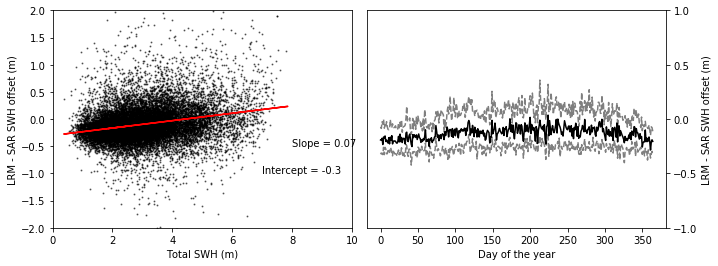

In [84]:
f=plt.figure(figsize=[11,4])
plt.subplot(1,2,1)
plt.scatter(swh_all.data[offset_mask].ravel(),offset[offset_mask].ravel(),s=1,c='k',alpha = 0.5)
#            c = offset_m[offset_mask].ravel())
# plt.colorbar()
plt.plot(x,bp+mp*x,'-r')
plt.text(8,-0.5,'Slope = '+str(round(mp,2)))
plt.text(7,-1,'Intercept = '+str(round(bp,2)))

plt.xlabel('Total SWH (m)')
plt.ylabel('LRM - SAR SWH offset (m)')
plt.xlim([0,10])
plt.ylim([-2,2])
ax = plt.subplot(1,2,2)
pp = plt.plot(offset_dy.clim_centile([25,50,75],time_set=[0,end_p]))
for i in [0,2]:
    pp[i].set_linestyle('dashed')
    pp[i].set_color('k')
    pp[i].set_alpha(0.5)
i = 1
pp[i].set_color('k')
plt.ylim([-1,1])
plt.ylabel('LRM - SAR SWH offset (m)')
plt.yticks([-1,-0.5,0.0,0.5,1.0])
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
# plt.plot(np.nanmean(offset,axis=(1,2)))
# plt.yticks([])
plt.xlabel('Day of the year')
plt.subplots_adjust(wspace=0.05)
plt.show()
f.savefig('Antarctic_mode_offsets.pdf',bbox_inches='tight')
# f.savefig('2011-2019_offset_comp.pdf',bbox_inches='tight')

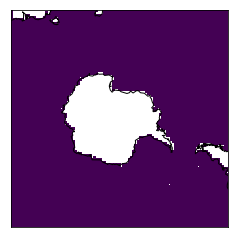

In [85]:
# need regional masking methods
m.pcolormesh(G.xpts,G.ypts,G.mask.T)
m.drawcoastlines()
plt.show()

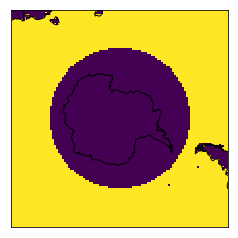

In [104]:
# to make a mask by lon lat ranges
# Nordic-Greenland
# Barents
# Kara
# Laptev
# E Siberian
# Beaufort Chuckchi
    # 176.4 to 156.2 to
    # 66.3 71
    
# Far south
lon_r = [-180,180]
lat_r = [-60,-20]
Southern_m = G.generate_mask_lonlat(lon_r,lat_r)
lon_r = [-60,-20]
lat_r = [-90,-60]
Weddel_m = G.generate_mask_lonlat(lon_r,lat_r)
# m.pcolormesh(G.xpts,G.ypts,Fsouth_m.T)
lon_r = [20,90]
lat_r = [-90,-60]
Indian_m = G.generate_mask_lonlat(lon_r,lat_r)
lon_r = [90,160]
lat_r = [-85,-60]
WestPacf_m = G.generate_mask_lonlat(lon_r,lat_r)
# m.pcolormesh(G.xpts,G.ypts,indian_m.T)
lon_r = [160,180]
lat_r = [-90,-60]
Ross1_m = G.generate_mask_lonlat(lon_r,lat_r)
lon_r = [-180,-130]
lat_r = [-90,-60]
Ross2_m = G.generate_mask_lonlat(lon_r,lat_r)
Ross_m = Ross1_m+Ross2_m
# m.pcolormesh(G.xpts,G.ypts,oceania_m.T)
lon_r = [-130,-60]
lat_r = [-90,-60]
BandA_m = G.generate_mask_lonlat(lon_r,lat_r)
# m.pcolormesh(G.xpts,G.ypts,pacific_m.T)
m.pcolormesh(G.xpts,G.ypts,Southern_m.T)
m.drawcoastlines()
plt.show()

Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array


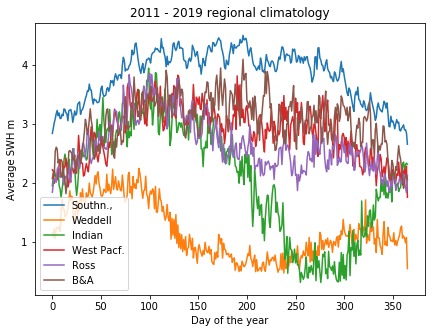

In [105]:
fig = plt.figure(figsize=[7,5])
# swh_all.build_mask()
swh_all.mask = False
swh_all.build_static_mask(Southern_m)
plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(Weddel_m)
plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(Indian_m)
plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(WestPacf_m)
plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(Ross_m)
plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(BandA_m)
plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
plt.ylabel('Average SWH m')
plt.xlabel('Day of the year')
plt.title('2011 - 2019 regional climatology')
# plt.legend(['Atlantic','Indian','Oceania','Pacific','Marginal'])
plt.legend(['Southn.,','Weddell','Indian','West Pacf.','Ross','B&A'])
plt.show()
# fig.savefig('Regions_clim.pdf',bbox_inches='tight')

Building new mask array


/Users/H/WAVES/geo_data_group/data_year.py:636: RuntimeWarning: Mean of empty slice
  axis = 0)


Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array


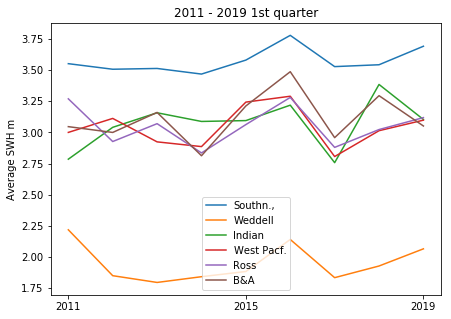

In [102]:
fig = plt.figure(figsize=[7,5])
# swh_all.build_mask()
periods = swh_all.get_periods(dt.datetime(2014,1,1),dt.datetime(2014,3,30))
swh_all.mask = False
swh_all.build_static_mask(Southern_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
swh_all.mask = False
swh_all.build_static_mask(Weddel_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
swh_all.mask = False
swh_all.build_static_mask(Indian_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
# plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(WestPacf_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
swh_all.mask = False
swh_all.build_static_mask(Ross_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
# plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(BandA_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
# plt.plot(swh_all.clim_mean(mask=True))
plt.ylabel('Average SWH m')
plt.xticks([0,4,8],['2011','2015','2019'])
plt.title('2011 - 2019 1st quarter')
# plt.plot(swh_all.clim_mean(mask=True))
# plt.legend(['Atlantic','Beaufort','Labrador','Barents','West Siberian','East Siberian'])
plt.legend(['Southn.,','Weddell','Indian','West Pacf.','Ross','B&A'])
plt.show()
# fig.savefig('3rd_quarter_year_lines.pdf',bbox_inches='tight')

/Users/H/WAVES/geo_data_group/data_year.py:464: RuntimeWarning: Mean of empty slice
  temp_array[pind] = np.nanmean(temp)
/Users/H/WAVES/geo_data_group/data_year.py:636: RuntimeWarning: Mean of empty slice
  axis = 0)
/Users/H/WAVES/geo_data_group/data_year.py:641: RuntimeWarning: Mean of empty slice
  temp_array[yy] = np.nanmean(temp)


Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array
Building new mask array


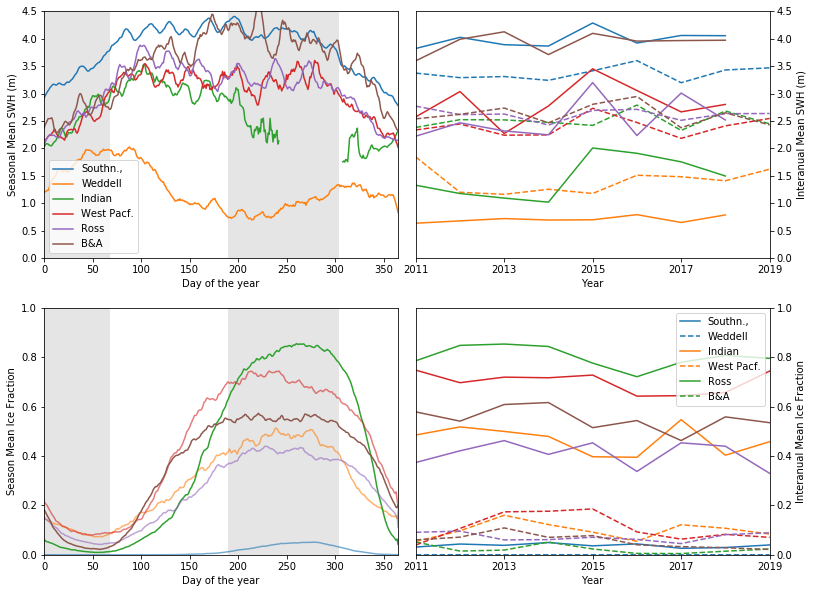

In [157]:
f = plt.figure(figsize=[13,10])
periods_W = swh_all.get_periods(dt.datetime(2014,7,10),dt.datetime(2014,11,1))
periods_S = swh_all.get_periods(dt.datetime(2014,1,1),dt.datetime(2014,3,10))
au=0.99
au2=0.99
# swh_all.build_mask()
plt.subplot(2,2,1)
plt.axvspan(periods_W[0],periods_W[-1], facecolor='k', alpha=0.1)
plt.axvspan(periods_S[0],periods_S[-1], facecolor='k', alpha=0.1)
# plt.axvline(periods_W[-1],color = 'k',linestyle = '--')
# plt.axvline(periods_S[0],color = 'k',linestyle = '--')
# plt.axvline(periods_S[-1],color = 'k',linestyle = '--')
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Southern_m)
plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au)
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Weddel_m)
plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au)
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Indian_m)
plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au2)
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(WestPacf_m)
plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au)
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Ross_m)
plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au)
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(BandA_m)
plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au2)
swh_all.mask = copy.copy(ocean_only_m)
# swh_all.build_static_mask(eastsib_m)
# plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au2)
# swh_all.mask = copy.copy(ocean_only_m)
# swh_all.build_static_mask(central_m)
# plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au)
# swh_all.mask = copy.copy(ocean_only_m)
# swh_all.build_static_mask(beaufort_m)
# plt.plot(swh_all.clim_mean(mask=True,moving_av=10),alpha=au2)
plt.ylim([0,4.5])
plt.xlim([0,365])
plt.ylabel('Seasonal Mean SWH (m)')
plt.xlabel('Day of the year')
# plt.legend(['N. Atlantic','Baffin Bay','Bering','Barents','Laptev','Kara','East Siberian','Central','Beaufort'])
plt.legend(['Southn.,','Weddell','Indian','West Pacf.','Ross','B&A'])

ax=plt.subplot(2,2,2)
# swh_all.build_mask()
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Southern_m)
p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Weddel_m)
p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Indian_m)
p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
# plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(WestPacf_m)
p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
# plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(Ross_m)
p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
# plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(BandA_m)
p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
swh_all.mask = copy.copy(ocean_only_m)
# swh_all.build_static_mask(eastsib_m)
# p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
# plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
#          color = p[0].get_color(),linestyle = '--')
# swh_all.mask = copy.copy(ocean_only_m)
# swh_all.build_static_mask(central_m)
# p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
# plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
#          color = p[0].get_color(),linestyle = '--')
# swh_all.mask = copy.copy(ocean_only_m)
# swh_all.build_static_mask(beaufort_m)
# p = plt.plot(swh_all.year_mean(periods=periods_W,mask=True))
# plt.plot(swh_all.year_mean(periods=periods_S,mask=True),
#          color = p[0].get_color(),linestyle = '--')
# plt.plot(swh_all.clim_mean(mask=True))
# plt.legend(['Atlantic','Beaufort','Labrador','Barents','West Siberian','East Siberian'])
# plt.legend(['Atlantic','Labrador','Barents','Laptev','Kara','East Siberian','Central','Beaufort'])
plt.xticks([0,2,4,6,8],['2011','2013','2015','2017','2019'])
plt.xlim([0,8])
plt.ylim([0,4.5])
plt.ylabel('Interanual Mean SWH (m)')
plt.xlabel('Year')
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.subplots_adjust(wspace=0.05)

# periods_S = ice_binned.get_periods(dt.datetime(2014,6,10),dt.datetime(2014,9,1))
# periods_W = ice_binned.get_periods(dt.datetime(2014,1,1),dt.datetime(2014,3,10))
au=0.6
au2=0.99
# ice_binned.build_mask()
plt.subplot(2,2,3)
plt.axvspan(periods_W[0],periods_W[-1], facecolor='k', alpha=0.1)
plt.axvspan(periods_S[0],periods_S[-1], facecolor='k', alpha=0.1)
# plt.axvline(periods_W[-1],color = 'k',linestyle = '--')
# plt.axvline(periods_S[0],color = 'k',linestyle = '--')
# plt.axvline(periods_S[-1],color = 'k',linestyle = '--')
ice_binned.mask = False
ice_binned.build_static_mask(Southern_m)
plt.plot(ice_binned.clim_mean(mask=True),alpha=au)
ice_binned.mask = False
ice_binned.build_static_mask(Weddel_m)
plt.plot(ice_binned.clim_mean(mask=True),alpha=au)
ice_binned.mask = False
ice_binned.build_static_mask(Indian_m)
plt.plot(ice_binned.clim_mean(mask=True),alpha=au2)
ice_binned.mask = False
ice_binned.build_static_mask(WestPacf_m)
plt.plot(ice_binned.clim_mean(mask=True),alpha=au)
ice_binned.mask = False
ice_binned.build_static_mask(Ross_m)
plt.plot(ice_binned.clim_mean(mask=True),alpha=au)
ice_binned.mask = False
ice_binned.build_static_mask(BandA_m)
plt.plot(ice_binned.clim_mean(mask=True),alpha=au2)
ice_binned.mask = False
# ice_binned.build_static_mask(eastsib_m)
# plt.plot(ice_binned.clim_mean(mask=True),alpha=au2)
# ice_binned.mask = False
# ice_binned.build_static_mask(central_m)
# plt.plot(ice_binned.clim_mean(mask=True),alpha=au)
# ice_binned.mask = False
# ice_binned.build_static_mask(beaufort_m)
# plt.plot(ice_binned.clim_mean(mask=True),alpha=au2)
plt.ylim([0,1])
plt.xlim([0,365])
plt.ylabel('Season Mean Ice Fraction')
plt.xlabel('Day of the year')
# plt.legend(['N. Atlantic','Baffin Bay','Bering','Barents','Laptev','Kara','East Siberian','Central','Beaufort'])

ax=plt.subplot(2,2,4)
# ice_binned.build_mask()
ice_binned.mask = False
ice_binned.build_static_mask(Southern_m)
p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
ice_binned.mask = False
ice_binned.build_static_mask(Weddel_m)
p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
ice_binned.mask = False
ice_binned.build_static_mask(Indian_m)
p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
# plt.plot(ice_binned.clim_mean(mask=True))
ice_binned.mask = False
ice_binned.build_static_mask(WestPacf_m)
p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
# plt.plot(ice_binned.clim_mean(mask=True))
ice_binned.mask = False
ice_binned.build_static_mask(Ross_m)
p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
# plt.plot(ice_binned.clim_mean(mask=True))
ice_binned.mask = False
ice_binned.build_static_mask(BandA_m)
p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
         color = p[0].get_color(),linestyle = '--')
ice_binned.mask = False
# ice_binned.build_static_mask(eastsib_m)
# p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
# plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
#          color = p[0].get_color(),linestyle = '--')
# ice_binned.mask = False
# ice_binned.build_static_mask(central_m)
# p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
# plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
#          color = p[0].get_color(),linestyle = '--')
# ice_binned.mask = False
# ice_binned.build_static_mask(beaufort_m)
# p = plt.plot(ice_binned.year_mean(periods=periods_W,mask=True))
# plt.plot(ice_binned.year_mean(periods=periods_S,mask=True),
#          color = p[0].get_color(),linestyle = '--')
# plt.plot(ice_binned.clim_mean(mask=True))
plt.legend(['Southn.,','Weddell','Indian','West Pacf.','Ross','B&A'])
# plt.legend(['Atlantic','Beaufort','Labrador','Barents','West Siberian','East Siberian'])
# plt.legend(['Atlantic','Labrador','Barents','Laptev','Kara','East Siberian','Central','Beaufort'])
plt.xticks([0,2,4,6,8],['2011','2013','2015','2017','2019'])
plt.xlim([0,8])
plt.ylim([0,1])
plt.ylabel('Interanual Mean Ice Fraction')
plt.xlabel('Year')

ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.subplots_adjust(wspace=0.05)
plt.show()
f.savefig('swh_and_ice_binned_clim_lines_ANTO.pdf',bbox_inches = 'tight')

/Users/H/WAVES/geo_data_group/data_year.py:455: RuntimeWarning: Mean of empty slice
  elif method=='median':
/Users/H/WAVES/geo_data_group/data_year.py:458: RuntimeWarning: Mean of empty slice
  


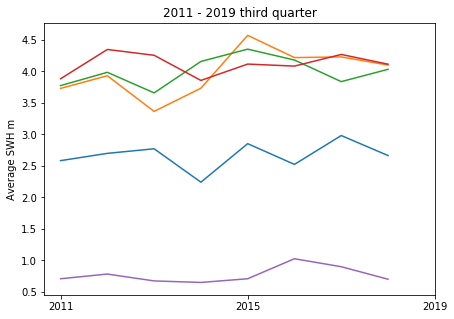

In [57]:
fig = plt.figure(figsize=[7,5])
# swh_all.build_mask()
periods = swh_all.get_periods(dt.datetime(2014,7,1),dt.datetime(2014,9,30))
swh_all.mask = False
swh_all.build_static_mask(atlantic_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
swh_all.mask = False
swh_all.build_static_mask(indian_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
swh_all.mask = False
swh_all.build_static_mask(oceania_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
# plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(pacific_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
# plt.plot(swh_all.clim_mean(mask=True))
swh_all.mask = False
swh_all.build_static_mask(Fsouth_m)
plt.plot(swh_all.year_mean(periods=periods,mask=True))
# plt.plot(swh_all.clim_mean(mask=True))
plt.ylabel('Average SWH m')
plt.xticks([0,4,8],['2011','2015','2019'])
plt.title('2011 - 2019 third quarter')
# plt.plot(swh_all.clim_mean(mask=True))
# plt.legend(['Atlantic','Beaufort','Labrador','Barents','West Siberian','East Siberian'])
plt.show()
# fig.savefig('3rd_quarter_year_lines.pdf',bbox_inches='tight')

/Users/H/WAVES/geo_data_group/data_year.py:565: RuntimeWarning: Mean of empty slice
  axis = 0)


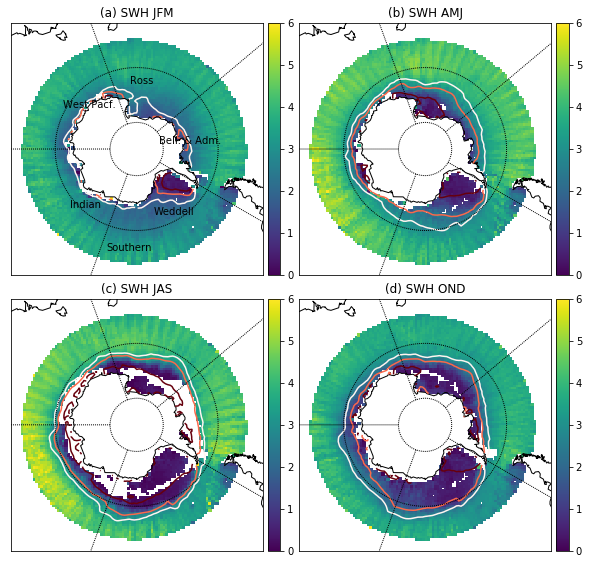

In [158]:
import matplotlib.pylab as pl
f = plt.figure(figsize=[10,10])
cmap_u = pl.cm.Reds
swh_m = 6
end_p = swh_all.n_t
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(np.isfinite(G.mask))
plt.subplot(2,2,1)
periods = swh_all.get_periods(dt.datetime(2014,1,1),dt.datetime(2014,3,31))
m.pcolormesh(G.xptp,G.yptp,swh_all.clim_map(periods=periods,mask=True,time_set=[0,end_p]).T)
plt.clim([0,swh_m])
m.colorbar(shrink=0.8)
m.contour(G.xptp,G.yptp,ice_binned.clim_map(periods=periods),[0.15,0.50,0.85],cmap = cmap_u)
m.drawcoastlines()
m.drawparallels([-60,-80])
m.drawmeridians([-130,-60,20,90,160])
plt.title('(a) SWH JFM')
plt.text(-G.dxRes*40,-G.dyRes*10,'Southern')
plt.text(-G.dxRes*60,-G.dyRes*25,'Weddell')
plt.text(-G.dxRes*25,-G.dyRes*28,'Indian')
plt.text(-G.dxRes*22,-G.dyRes*70,'West Pacf.')
plt.text(-G.dxRes*50,-G.dyRes*80,'Ross')
plt.text(-G.dxRes*62,-G.dyRes*55,'Bell. & Adm.')

plt.subplot(2,2,2)
periods = swh_all.get_periods(dt.datetime(2014,4,1),dt.datetime(2014,6,30))
m.pcolormesh(G.xptp,G.yptp,swh_all.clim_map(periods=periods,mask=True,time_set=[0,end_p]).T)
m.drawcoastlines()
plt.clim([0,swh_m])
m.colorbar(shrink=0.8)
m.contour(G.xptp,G.yptp,ice_binned.clim_map(periods=periods),[0.15,0.50,0.85],cmap = cmap_u)
m.drawparallels([-60,-80])
m.drawmeridians([-130,-60,20,90,160])
plt.title('(b) SWH AMJ')

plt.subplot(2,2,3)
periods = swh_all.get_periods(dt.datetime(2014,7,1),dt.datetime(2014,9,30))
m.pcolormesh(G.xptp,G.yptp,swh_all.clim_map(periods=periods,mask=True,time_set=[0,end_p]).T)
m.drawcoastlines()
plt.clim([0,swh_m])
m.colorbar(shrink=0.8)
m.contour(G.xptp,G.yptp,ice_binned.clim_map(periods=periods),[0.15,0.50,0.85],cmap = cmap_u)
m.drawparallels([-60,-80])
m.drawmeridians([-130,-60,20,90,160])
plt.title('(c) SWH JAS')

plt.subplot(2,2,4)
periods = swh_all.get_periods(dt.datetime(2014,10,1),dt.datetime(2014,12,30))
m.pcolormesh(G.xptp,G.yptp,swh_all.clim_map(periods=periods,mask=True,time_set=[0,end_p]).T)
m.drawcoastlines()
plt.clim([0,swh_m])
m.colorbar(shrink=0.8)
m.contour(G.xptp,G.yptp,ice_binned.clim_map(periods=periods),[0.15,0.50,0.85],cmap = cmap_u)
m.drawparallels([-60,-80])
m.drawmeridians([-130,-60,20,90,160])
plt.title('(d) SWH OND')
plt.subplots_adjust(wspace=0.07,hspace=0.03)
plt.show()
f.savefig('Clim_maps_quarters_ANTO.pdf',bbox_inches='tight')

/Users/H/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


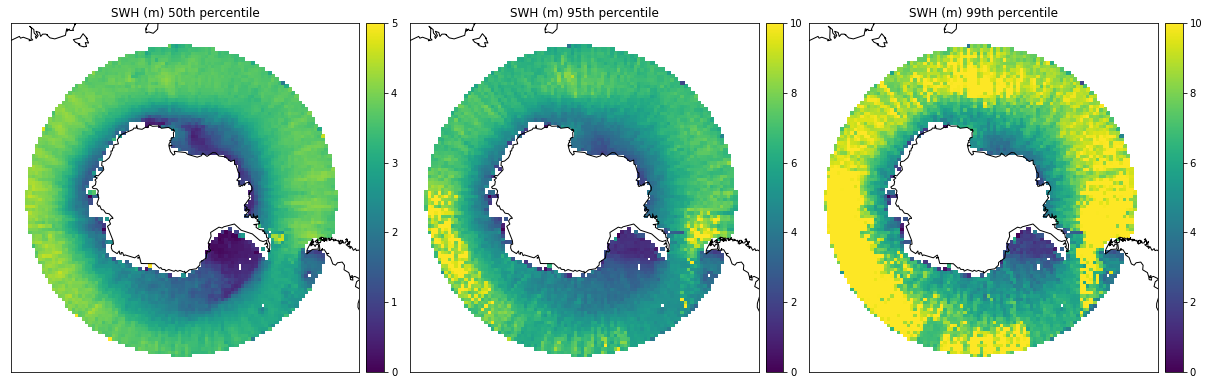

In [169]:
f=plt.figure(figsize=[21,7])
date_u = dt.datetime(2018,3,22)
inds = swh_all.get_index(date_u)
swh_all.mask = False
swh_all.mask = copy.copy(ocean_only_m)
swh_all.build_static_mask(np.isfinite(G.mask))
periods = swh_all.get_periods(dt.datetime(2014,1,1),dt.datetime(2014,12,30))
plt.subplot(1,3,1)
plt.title('SWH (m) 50th percentile')
m.pcolor(G.xptp,G.yptp,swh_all.centile_map(50,periods=periods,mask=True).T)
plt.clim([0,5])
m.drawcoastlines()
m.colorbar(shrink=0.8)
plt.subplot(1,3,2)
plt.title('SWH (m) 95th percentile')
m.pcolor(G.xptp,G.yptp,swh_all.centile_map(95,periods=periods,mask=True).T)
plt.clim([0,10])
m.drawcoastlines()
m.colorbar(shrink=0.8)
plt.subplot(1,3,3)
plt.title('SWH (m) 99th percentile')
m.pcolormesh(G.xptp,G.yptp,swh_all.centile_map(99,periods=periods,mask=True).T)
m.colorbar(shrink=0.8)
# inds = ice_binned.get_index(date_u)
# m.contour(G.xptp,G.yptp,ice_binned[inds,:,:].T,[0.15,0.50,0.85],cmap = pl.cm.Greens_r)
# plt.clim([0,100])
plt.clim([0,10])
m.drawcoastlines()
plt.subplots_adjust(wspace=0.07,hspace=0.03)
# plt.title('SWH (m)')
plt.show()
f.savefig('SWH_all_percentiles_ANTO.pdf',bbox_inches = 'tight')

In [37]:
periods = swh_all.get_periods(dt.datetime(2014,1,1),dt.datetime(2014,3,31))
swh_all.year_mean(periods=periods)

/Users/H/WAVES/geo_data_group/data_year.py:370: RuntimeWarning: Mean of empty slice
  axis = 0)


array([2.49834154, 2.71682256, 2.35720213, 2.45050299, 2.707023  ,
       2.47572299, 2.50324839, 2.44353184, 2.54239744])

In [21]:
periods = np.arange(30,35)
y0=1
yE=7
idx = [swh_all.yrpd[y0:yE+1,mn].compressed() for mn in periods]

In [22]:
pu,yu = np.shape(idx)
# idx
for yy in range(yu):
    temp      = np.empty([pu,self.m,self.n])
    temp_mask = np.sum([mask[i[yy]] for i in idx if i[yy]>=t0 and i[yy]<=tE],
            axis = 0)
    temp = np.nanmean(
            [swh_all.data[i[yy]] for i in idx if i[yy]>=t0 and i[yy]<=tE],
            axis = 0)
    temp[temp_mask==False] = np.nan
    if method=='mean':
        temp_array[yy] = np.nanmean(temp)
    elif method=='median':
        temp_array[yy] = np.nanmedian(temp)


(5, 7)

In [21]:
np.sum(np.isfinite(swh_all.data))

55082

In [20]:
swh_all.mask = False
swh_all.build_static_mask(np.isfinite(G.mask))

/Users/H/WAVES/geo_data_group/data_year.py:385: RuntimeWarning: Mean of empty slice
  def centile_map(self,centile,periods=[],mask = False,year_set = [],time_set = []):


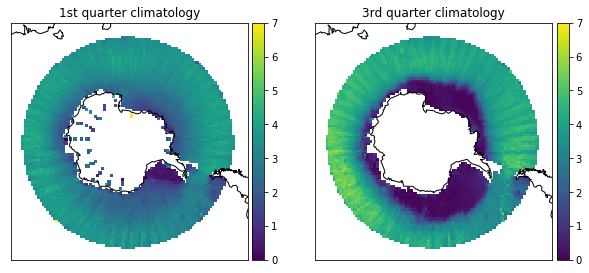

In [45]:
end_p = swh_all.n_t
fig = plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.title('1st quarter climatology')
# periods = swh_all.get_periods(dt.datetime(2011,8,1),dt.datetime(2011,10,31))
periods = swh_all.get_periods(dt.datetime(2011,1,11),dt.datetime(2011,4,1))
m.pcolormesh(G.xpts,G.ypts,swh_all.clim_map(periods=periods,mask=False,time_set=[0,end_p]).T)
m.drawcoastlines()
m.colorbar(shrink=0.8)
plt.clim([0,7])
# plt.show()
plt.subplot(1,2,2)
plt.title('3rd quarter climatology')
periods = swh_all.get_periods(dt.datetime(2011,7,1),dt.datetime(2011,9,30))
m.pcolormesh(G.xpts,G.ypts,swh_all.clim_map(periods=periods,mask=False,time_set=[0,end_p]).T)
m.drawcoastlines()
m.colorbar(shrink=0.8)
plt.clim([0,7])
plt.show()
# fig.savefig('SWH_clim_maps.pdf',bbox_inches='tight')

/Users/H/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


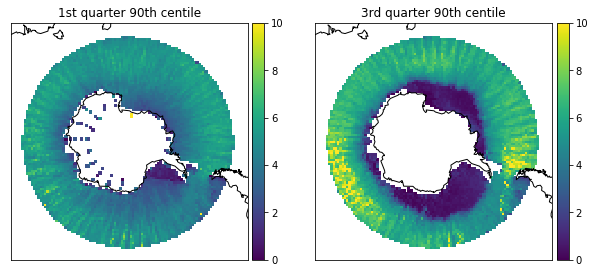

In [60]:
end_p = swh_all.n_t
fig = plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.title('1st quarter 90th centile')
# periods = swh_all.get_periods(dt.datetime(2011,8,1),dt.datetime(2011,10,31))
periods = swh_all.get_periods(dt.datetime(2011,1,11),dt.datetime(2011,4,1))
m.pcolormesh(G.xpts,G.ypts,swh_all.centile_map(90,periods=periods,mask=False,time_set=[0,end_p]).T)
m.drawcoastlines()
m.colorbar(shrink=0.8)
plt.clim([0,10])
# plt.show()
plt.subplot(1,2,2)
plt.title('3rd quarter 90th centile')
periods = swh_all.get_periods(dt.datetime(2011,7,1),dt.datetime(2011,9,30))
m.pcolormesh(G.xpts,G.ypts,swh_all.centile_map(90,periods=periods,mask=False,time_set=[0,end_p]).T)
# m.pcolormesh(G.xpts,G.ypts,swh_all.clim_map(periods=periods,mask=False,time_set=[0,end_p]).T)
m.drawcoastlines()
m.colorbar(shrink=0.8)
plt.clim([0,10])
plt.show()
# fig.savefig('SWH_clim_maps.pdf',bbox_inches='tight')

In [ ]:
ax.axes.yaxis_inverted()

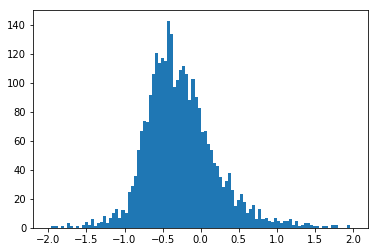

In [167]:
plt.hist(offset[offset_mask].ravel(),bins=100,range=[-2e0,2e0])
# plt.hist(jan_o[np.isfinite(jan_o)].ravel(),bins=100)
plt.show()

In [28]:
def plot_swh(tp,swh,gs,dstep):
    fig = plt.figure(figsize=[10,10])
    gs.mplot.pcolormesh(gs.xpts,gs.ypts,swh[tp].T)
    gs.mplot.colorbar()
    gs.mplot.drawcoastlines()
    plt.clim([0,6.0])
    plt.title(this_day.date.strftime('%Y-%m-( %d')+
      'to'+str(this_day.date.day+dstep)+')')
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return image

In [18]:
def plot_swh_double(tp,swh_all,swh_fill,aice,gs,dstep):
    fig = plt.figure(figsize=[10,5])
    plt.subplot(1,2,1)
    gs.mplot.pcolormesh(gs.xpts,gs.ypts,swh_all[tp,:,:].T)
    gs.mplot.colorbar()
    gs.mplot.drawcoastlines()
    plt.clim([0,6.0])
    aice.contour(gs.mplot,[0.15,0.5])
    plt.title(this_day.date.strftime('%Y-%m-( %d')+
      'to'+str(this_day.date.day+dstep)+')')
    plt.subplot(1,2,2)
    gs.mplot.pcolormesh(gs.xpts,gs.ypts,swh_fill[tp,:,:].T)
    gs.mplot.colorbar()
    gs.mplot.drawcoastlines()
    plt.clim([0,6.0])
    aice.contour(gs.mplot,[0.15,0.5])
    plt.title(this_day.date.strftime('%Y-%m-( %d')+
      'to'+str(this_day.date.day+dstep)+')')
    fig.tight_layout(pad=0)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    fig.set_constrained_layout(True)
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return image

In [20]:
aice = ic.NSIDC_IC(this_day.date)
this_day.date = dt.datetime(2012,8,1)
aice.new_ice(this_day.date)
images = []
dstep = 1
for tt in range(tp-1):
# for tt in range(1):
    images.append(
        plot_swh_double(tt,swh_all,swh_fill,aice,this_day,dstep)
#         plot_swh(tt,swh_fill,this_day,dstep)
                    )
    this_day.date += relativedelta(days=dstep)
    aice.new_ice(this_day.date)
imageio.mimsave('First_saves_2014/100km_1d_2012-08_fill.gif', images, fps=1)

In [7]:
swh_all[0,:,:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
# filter it

# bin it

# attempt a fill
# need a mask: land plus lon/lat lims
# ice mask too perhaps??

# save
# save each time slice or loop and build up a months?

# test days 1,5,10

# test res 50k 100k

# make a sexy gif